In [3]:
import os
import sys
import cv2
import glob 
import torch
import random 
import resource 
import numpy as np
from math import exp
import torch.nn as nn 
from PIL import Image
from models.memae import *
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader  
 

In [4]:
def gaussian(window_size, sigma):
    """
    Args:
        window_size: Size of Gaussian window
        sigma: mean for the gaussian

    Returns:
        gauss. a gaussian matrix with mean equal to sigma and size equal to window size 
    """
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    """
    Args:
        window_size: Size of Gaussian window
        channel: number of channels in the gaussian filter

    Returns:
        window: Gaussian tensor
    """
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = False):
    """
    Args:
        img1: image one to be compared
        img2: image two to be compared
        window: the Gaussian window
        window_size: size of the Gaussian Window
        channel: number of output channels
        size_average: take mean of the final similarity matrix or not

    Returns:
        ssim_map: Structural similarity index of two images
    """
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average and False: 
        return ssim_map.mean()
    else:
        return ssim_map
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    """ 
    Class for SSIM loss 
      
    Attributes: 
        size_average: Take mean of the loss or not 
        window_size: size of similarity window 
    """
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)
         
    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel

        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

 

In [5]:
class MemDataset(Dataset):
    """Memory Auto Encoder Dataset"""

    def __init__(self,root_dir,start,end,train=True):
        """
        Args:
            root_dir : Directory with all the images.
            start : starting index of images to include in this set
            end : ending index of images to include in this set
            train : train or test
        """
        self.transform=transforms.Compose([    transforms.Resize((98,98)), 
                                               transforms.Grayscale(num_output_channels=1),
                                               transforms.ToTensor()
                                           ])
        self.train = train
        self.dataset = glob.glob(root_dir)[start:end] 
       

    def __len__(self):
        """
        returns total number of samples in dataset
        """
        return len(self.dataset)

    def __getitem__(self, idx):
        img_name = self.dataset[idx]
        im = np.array(Image.open(img_name))  
        im = Image.fromarray(im) 
        im = self.transform(im)
        return im,im
    
train_good = MemDataset('../defect/datasets/infineon/train_memae/train/*',0,10000)
test_good = MemDataset('../defect/datasets/infineon/train_memae/test/*',0,10000,False)
test_bad = MemDataset('../defect/datasets/infineon/test/baad/*',00,1000,False)

print ("Train Good",train_good.__len__(), "\nTest defective", test_bad.__len__(),"\nTest good", test_good.__len__())

train_loader = torch.utils.data.DataLoader(train_good,batch_size=64, shuffle=True,
                                             num_workers=4)
test_loader_bad = torch.utils.data.DataLoader(test_bad,batch_size=1, shuffle=False,
                                             num_workers=4)
test_loader_good = torch.utils.data.DataLoader(test_good,batch_size=1, shuffle=False,
                                             num_workers=4)


Train Good 8491 
Test defective 462 
Test good 462


In [6]:
# Create model object with 1000 memory locations
model = MEMAE(1000).cuda()
# Load weights
model.load_state_dict(torch.load("./ckpts/97_4.pt")) 
model.train()

 

MEMAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 16, kernel_size=(1, 1), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
    (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (cosine_similarity): CosineSimilarity()
  (decoder): Decoder(
    (deconv0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
    (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (deconv1): ConvTranspose2d(64, 32, kerne

In [9]:
 
def train(model,dataloader,criteria,optimizer,train=True,step=100):
    """
    Args:
        model: Memory Augmented Auto Encoder
        dataloader: Image dataloader
        criteria: Loss function, L2 or SSIM
        optimizer: the optimizer used for training, default is Adam
        train: train or test set
        step: step after which image will be shown

    Returns:
        losses: A list of losses on all test images
    """
    
    losses = list() 
    if not train:
        model.eval()
    else:
        model.train()
    for i,(im,lab) in enumerate(dataloader):
        optimizer.zero_grad() 
        outputs = model(im.cuda())  
        #Minimize the similarity difference
        loss =  1-criteria(outputs, lab.cuda()) 
        refiner_output = 1- criteria(outputs,model(outputs))
        blur = cv2.GaussianBlur(loss.clone().cpu().detach().numpy()[0].reshape(98,98),(9,9),0)
        refiner_output = refiner_output.cpu().detach().numpy()[0].reshape(98,98)
        refined_loss = blur - refiner_output
        refined_loss = np.sort(refined_loss.reshape(-1)) 
        error = np.median(refined_loss)*np.median(refined_loss[-45:])
        losses.append(error)
        phase = "Train" if train else "Test" 
        if i % step == 0 and  not train:
            print (phase," Iteration: ",i,"LOSS : ",np.mean(refined_loss),"min:",np.min(refined_loss),"max:",np.max(refined_loss)\
               ,"med:",np.median(refined_loss),"zero:",refined_loss[refined_loss==0].shape) 
            inn = im.cpu().detach().numpy()[0]
            inn = np.transpose(inn,(1,2,0)) 
            outputs = outputs.cpu().detach().numpy()[0]  
            outputs[outputs>1]=1
            outputs = np.transpose(outputs,(1,2,0))[:,:,0] 
            
            
            plt.imshow(inn.reshape(98,98),cmap="gray")#.cpu().detach().numpy().reshape(98,98),cmap="gray")
            plt.show()
            plt.imshow(outputs,cmap="gray")
            plt.show() 
        if train:
            loss.mean().backward()
            optimizer.step()
    
    return losses

def calculate_acc(loss_lists):
    """
    Args:
        loss_lists: list of losses for bad and good test images
    Returns:
        accuracy, thres: Best accuracy and threshold calculated from losses
    """
    neg_np =  (np.array(loss_lists[0]))
    pos_np =  (np.array(loss_lists[1]))
    pos_np *=1000
    neg_np *=1000
    start,end = np.median(pos_np),np.median(neg_np) 
    
    thresholds = np.linspace(0, end, num=1000)
    accuracy = 0
    thres = 0
    print (pos_np.shape,neg_np.shape)
    accs = list()
    defects = list()
    normal = list()
    for threh in thresholds: 
        current_acc = ((pos_np[pos_np<threh].shape[0])+(neg_np[neg_np>=threh].shape[0])) / (pos_np.shape[0]+neg_np.shape[0])
        accs.append(current_acc)
        defects.append(neg_np[neg_np>=threh].shape)
        normal.append(pos_np[pos_np<threh].shape)
        if accuracy < current_acc:
            accuracy = current_acc
            thres  = threh
    plt.ylabel("True Negative")
    plt.xlabel("Threshold")
    plt.plot(thresholds,accs)
    plt.show()
    print (accuracy,thres)
    print ("Positive",pos_np[pos_np<thres].shape,"Anomaly",neg_np[neg_np>=thres].shape, "Distribution")
    return accuracy,thres

Epoch ___________________________________ 1
Test  Iteration:  0 LOSS :  0.010197627 min: -0.00030090142 max: 0.17540278 med: 0.0075576254 zero: (0,)


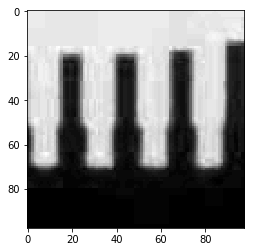

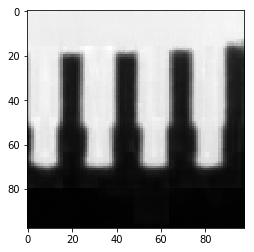

Test  Iteration:  0 LOSS :  0.008466356 min: -0.0002903099 max: 0.057150226 med: 0.00637405 zero: (0,)


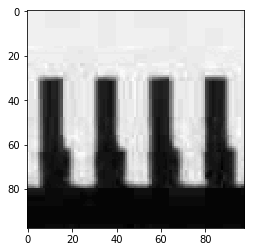

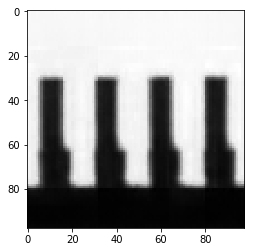

(462,) (462,)


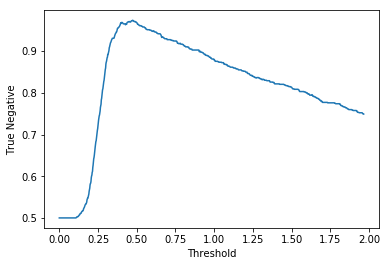

0.974025974025974 0.4741227909609362
Positive (450,) Anomaly (450,) Distribution
ACCURACY:  0.974025974025974 THRESHOLD:  0.4741227909609362


In [10]:
criteria = nn.MSELoss(reduction='none' ).cuda()
s_loss = SSIM().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0051)
phases = {"test":[test_loader_bad,test_loader_good],"train":train_loader}

epoch = 0
max_acc = 0

while True:
    epoch+=1
    print ("Epoch ___________________________________",epoch)
    if epoch ==10000:
        break
    for phase in phases:
        loaders = phases[phase]
        if phase == 'train': 
            continue
            train(model,loaders,s_loss,optimizer,True,50)
        else: 
            loss_lists = list()
            for loader in loaders:
                losses = train(model,loader,s_loss,optimizer,False,1000)
                loss_lists.append(losses)
            acc,thr = calculate_acc(loss_lists)
            print ("ACCURACY: ",acc, "THRESHOLD: ",thr)
#             if max_acc < acc or True:
#                 torch.save(model.state_dict(),str(acc)+".pt")
#                 max_acc = acc
    break
 
